# **YOLO Coin Detection and Classification**

*   Environment setup
*   Dataset Extracion
*   Splitting into train/val
*   YOLO config file creation
*   Training, prediction, and evaluation
*   Exporting and downloading the trained model




# **Step 1: Setup GPU and Install Dependencies**

In [1]:
# Verify NVIDIA GPU Availability
!nvidia-smi

Tue Apr 22 04:56:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
!pip install ultralytics

# **Step 2: Dataset Extraction**

In [13]:
# Unzip images to a unzip_data folder
!unzip -q /content/data.zip -d /content/unzip_data

# **Step 3: Split images into train and validation folders**

In [14]:
# Split between train and val folders

from pathlib import Path
import random
import os
import sys
import shutil
import argparse

data_path = '/content/unzip_data'
train_percent = 0.9

# Check for valid entries
if not os.path.isdir(data_path):
   print('Directory specified by --datapath not found. Verify the path is correct (and uses double back slashes if on Windows) and try again.')
   sys.exit(0)
if train_percent < .01 or train_percent > 0.99:
   print('Invalid entry for train_pct. Please enter a number between .01 and .99.')
   sys.exit(0)
val_percent = 1 - train_percent

# Define path to input dataset
input_image_path = os.path.join(data_path,'images')
input_label_path = os.path.join(data_path,'labels')

# Define paths to image and annotation folders
cwd = os.getcwd()
train_img_path = os.path.join(cwd,'data/train/images')
train_txt_path = os.path.join(cwd,'data/train/labels')
val_img_path = os.path.join(cwd,'data/validation/images')
val_txt_path = os.path.join(cwd,'data/validation/labels')

# Create folders if they don't already exist
for dir_path in [train_img_path, train_txt_path, val_img_path, val_txt_path]:
   if not os.path.exists(dir_path):
      os.makedirs(dir_path)
      print(f'Created folder at {dir_path}.')


# Get list of all images and annotation files
img_file_list = [path for path in Path(input_image_path).rglob('*')]
txt_file_list = [path for path in Path(input_label_path).rglob('*')]

print(f'Number of image files: {len(img_file_list)}')
print(f'Number of annotation files: {len(txt_file_list)}')

# Determine number of files to move to each folder
file_num = len(img_file_list)
train_num = int(file_num*train_percent)
val_num = file_num - train_num
print('Images moving to train: %d' % train_num)
print('Images moving to validation: %d' % val_num)

# Select files randomly and copy them to train or val folders
for i, set_num in enumerate([train_num, val_num]):
  for ii in range(set_num):
    img_path = random.choice(img_file_list)
    img_fn = img_path.name
    base_fn = img_path.stem
    txt_fn = base_fn + '.txt'
    txt_path = os.path.join(input_label_path,txt_fn)

    if i == 0: # Copy first set of files to train folders
      new_img_path, new_txt_path = train_img_path, train_txt_path
    elif i == 1: # Copy second set of files to the validation folders
      new_img_path, new_txt_path = val_img_path, val_txt_path

    shutil.copy(img_path, os.path.join(new_img_path,img_fn))
    #os.rename(img_path, os.path.join(new_img_path,img_fn))
    if os.path.exists(txt_path): # If txt path does not exist, this is a background image, so skip txt file
      shutil.copy(txt_path,os.path.join(new_txt_path,txt_fn))
      #os.rename(txt_path,os.path.join(new_txt_path,txt_fn))

    img_file_list.remove(img_path)

Number of image files: 387
Number of annotation files: 387
Images moving to train: 348
Images moving to validation: 39


# **Step 4: Create data.yaml for YOLO Training**

In [15]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/unzip_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 5
names:
- '1'
- '10'
- '2'
- '5'
- 50p


# **Step 5: Train YOLOv11s Model**


In [16]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=30 imgsz=640

100% 18.4M/18.4M [00:00<00:00, 197MB/s]
Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

# **Step 6: Make Predictions**

In [17]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/76 /content/data/validation/images/0485ece5-10_15.jpg: 640x640 1 10, 15.7ms
image 2/76 /content/data/validation/images/05a69436-1_8.jpg: 640x640 1 1, 15.7ms
image 3/76 /content/data/validation/images/065b9a52-10_33.jpg: 640x640 1 10, 15.6ms
image 4/76 /content/data/validation/images/07e0bd22-2_31.jpg: 640x640 1 2, 15.6ms
image 5/76 /content/data/validation/images/097366b3-2_57.jpg: 640x640 1 2, 15.6ms
image 6/76 /content/data/validation/images/0acb3ea8-2_47.jpg: 640x640 1 2, 15.6ms
image 7/76 /content/data/validation/images/0cb3929e-1_56.jpg: 480x640 1 1, 46.0ms
image 8/76 /content/data/validation/images/0fa28b53-1_58.jpg: 640x480 1 1, 48.1ms
image 9/76 /content/data/validation/images/1022a86b-10_4.jpg: 640x640 1 10, 15.7ms
image 10/76 /content/data/validation/images/16181299-1_59.jpg: 480x640 1 1, 12.6ms
image 1

# **Step 7: Visualize Predictions**

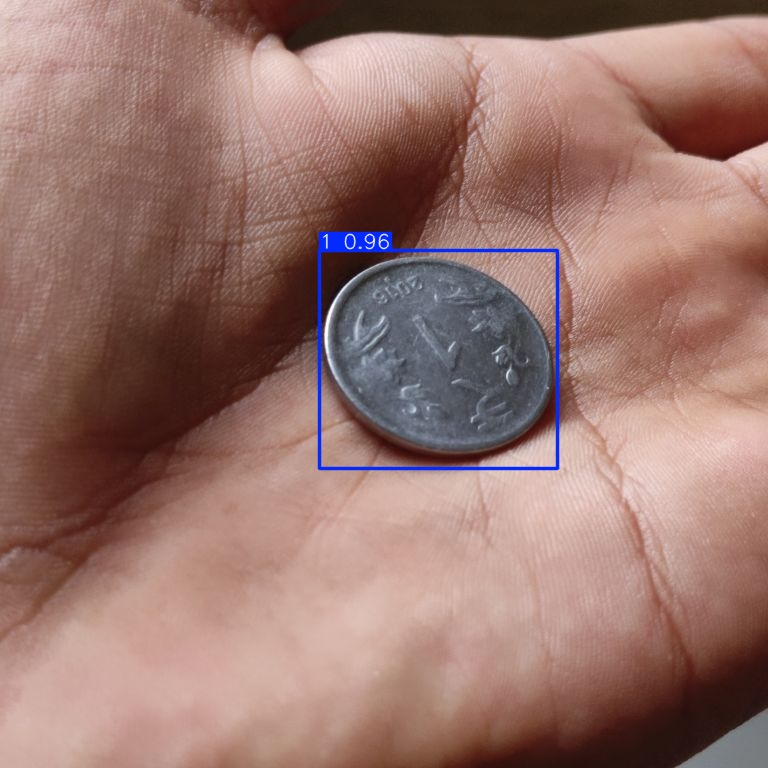

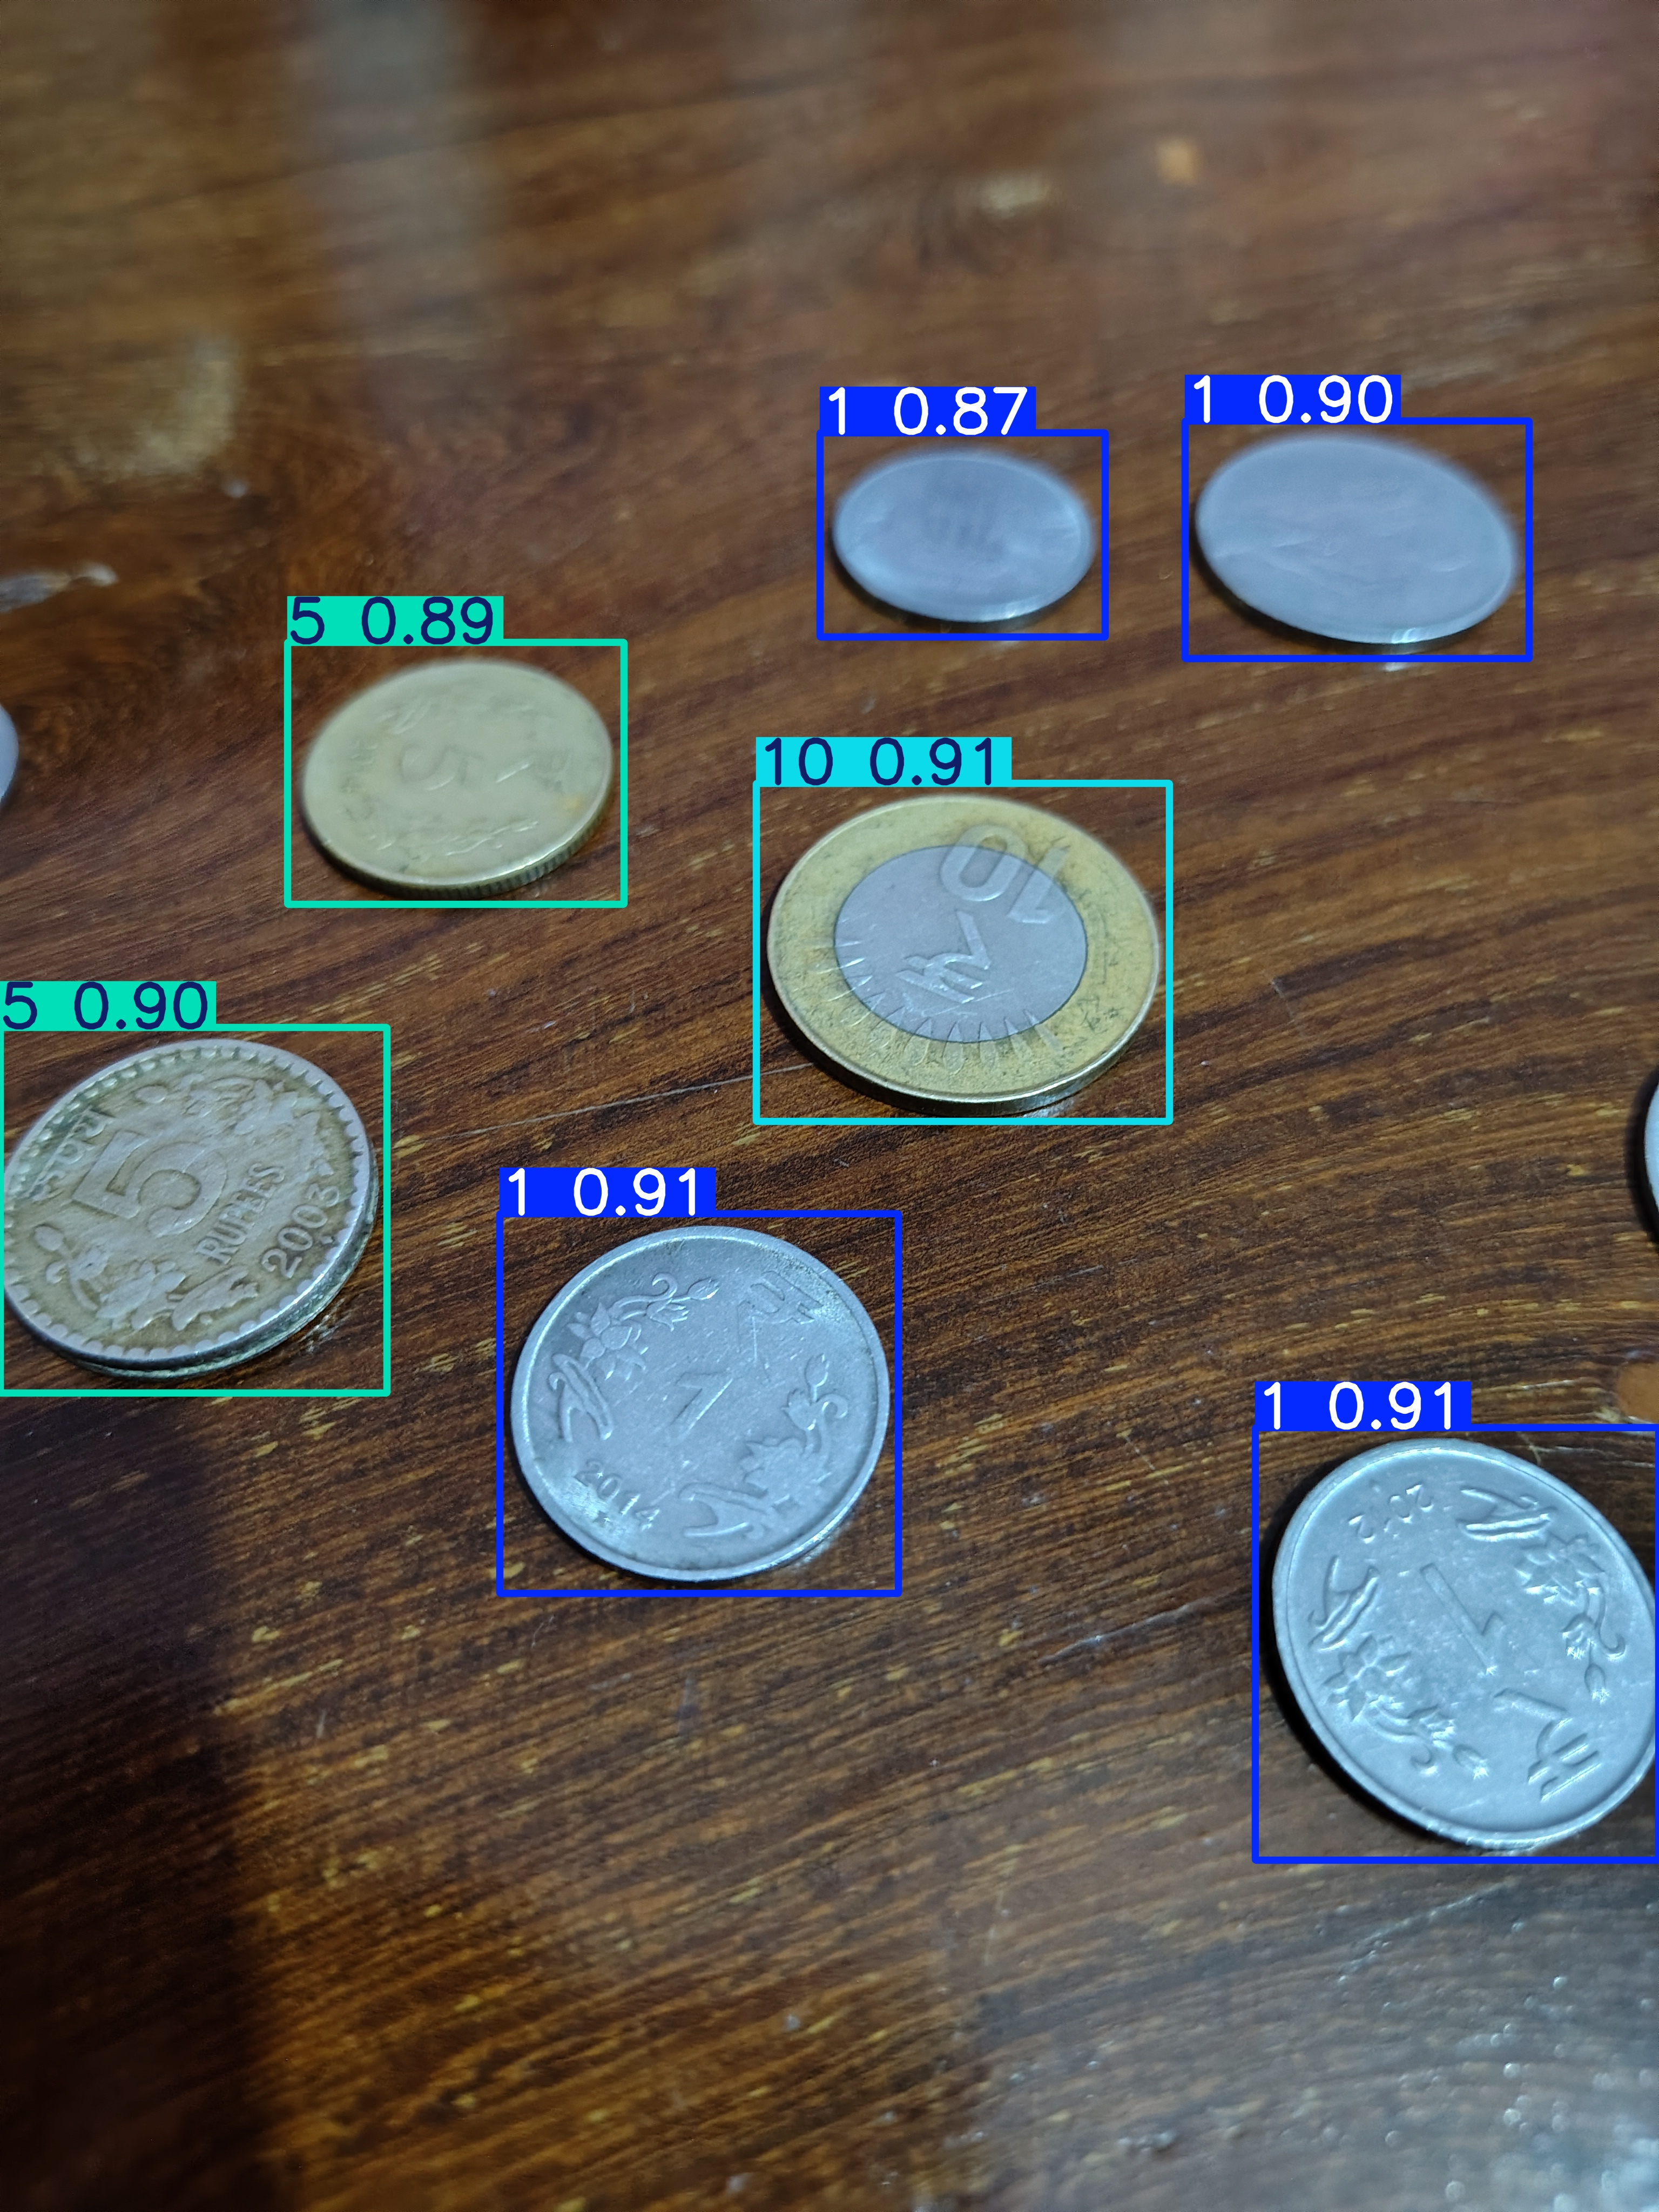

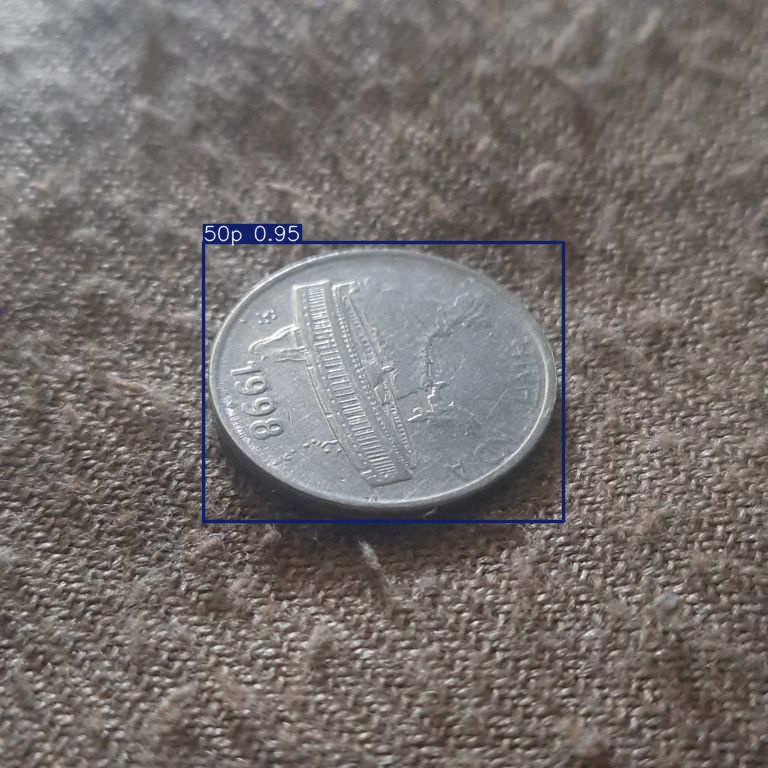

In [22]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[5:8]:
  display(Image(filename=image_path, height=400))
  print('\n')